# Qualificação de Prospects: Como Identificar e Focar nos Clientes Certos

## Definindo e Compreendendo o Problema a Ser Resolvido

#### **Problema a ser Resolvido**
Uma empresa X recebe contatos de clientes interessados em seus produtos ou serviços através de diferentes canais (Facebook, Google Ads, Instagram, LinkedIn, entre outros). No entanto, nem todos os clientes que entram em contato realmente fecham um contrato. Atualmente, os atendentes dedicam tempo a todos os prospects de maneira indiscriminada, sem uma estratégia baseada em dados. Isso gera desperdício de recursos e tempo, impactando negativamente a eficiência do setor comercial.

O desafio é identificar padrões nos dados dos clientes para prever a probabilidade de conversão no momento do primeiro contato. Se a empresa conseguir antecipar quais prospects têm maior probabilidade de fechar contrato, os atendentes poderão priorizar esses contatos e otimizar esforços de venda.

#### **Objetivo da Análise**
O objetivo deste estudo é desenvolver um modelo de Machine Learning capaz de prever a probabilidade de um cliente fechar contrato com base em características como:

- **Fonte do Contato** (de onde veio o lead)
- **Nível de Interesse no Produto** (escala de 1 a 5)
- **Orçamento Disponível** (capacidade de investimento do cliente)
- **Tempo de Resposta** (em minutos, indicando quão rápido ele retornou o contato)
- **Experiência no Setor** (tempo de atuação do cliente no segmento relacionado)
- **Score de Qualificação** (avaliação do prospect feita pelo atendente)

A variável de saída será **"Fechou_Contrato"** (1 para clientes que fecharam contrato e 0 para os que não fecharam).

Com essa análise, pretendemos:

1. **Identificar padrões nos prospects qualificados** para prever se um cliente tem alta ou baixa probabilidade de conversão.
2. **Auxiliar a equipe de vendas na tomada de decisão**, garantindo que os esforços sejam direcionados para os clientes com maior potencial de fechamento.
3. **Reduzir tempo desperdiçado com leads de baixa qualidade** e melhorar a eficiência operacional.
4. **Maximizar a taxa de conversão**, otimizando a alocação dos recursos de atendimento.

## Etapa 1 - Instalando e Carregando os Pacotes

In [1]:
import warnings                                                                                 # Controle de alertas
warnings.filterwarnings('ignore')                                                               # Ignora avisos para manter a saída do código mais limpa

In [2]:
# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import pickle                                                                                   # Para salvar e carregar modelos treinados
import sklearn as sk                                                                            # Biblioteca para aprendizado de máquina
import pandas as pd                                                                             # Manipulação de dados em DataFrames
import numpy as np                                                                              # Operações matemáticas e manipulação de arrays
import seaborn as sns                                                                           # Visualização de dados estatísticos
import matplotlib.pyplot as plt                                                                 # Biblioteca para criação de gráficos
import xgboost as xgb                                                                           # Implementação do algoritmo XGBoost
from xgboost import XGBClassifier                                                               # Classificador baseado em XGBoost
from sklearn.linear_model import LogisticRegression                                             # Regressão logística para classificação
from sklearn.naive_bayes import GaussianNB                                                      # Classificador Naïve Bayes Gaussiano
from sklearn.preprocessing import StandardScaler                                                # Padronização dos dados (média 0, variância 1)
from sklearn.model_selection import cross_val_score, GridSearchCV                               # Validação cruzada e busca de hiperparâmetros
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve  # Métricas de avaliação
from sklearn.model_selection import train_test_split
# Garante que os gráficos sejam exibidos diretamente no notebook (caso esteja rodando no Jupyter)
%matplotlib inline  

In [3]:
%reload_ext watermark
%watermark -a "Ricardo de Souza Silva"

Author: Ricardo de Souza Silva



## Etapa 2 - Compreensão dos Dados


Para aprimorar a análise e melhorar a robustez do modelo, geramos um novo conjunto de **1.000 registros de clientes** contendo os atributos mencionados acima. Esses dados simulam uma variedade de cenários e padrões de comportamento de prospects, permitindo uma análise mais precisa e a construção de um modelo preditivo eficiente.

## Etapa 3 - Carregando os Dados

In [4]:
# lista para identificar valores ausentes
lista_labels_valores_ausentes = ["n/a,", "na", "undefined"]

In [5]:
dataset = pd.read_csv('LeadPredict.csv', na_values=lista_labels_valores_ausentes)

In [6]:
dataset.head()

,ID_Cliente,Fonte_Contato,Interesse_Produto,Orçamento_Disponível,Tempo_Resposta,Experiência_Setor,Score_Qualificação,Fechou_Contrato
0,1,Instagram,4,7647,1435,1,68,1
1,2,LinkedIn,5,4951,1224,7,12,0
2,3,Referência,3,15843,315,11,86,1
3,4,Referência,5,14135,266,4,57,1
4,5,Orgânico,5,6459,410,6,49,0


## Etapa 4 - Análise Exploratória e Definição da Variável Alvo

In [7]:
dataset.columns

Index(['ID_Cliente', 'Fonte_Contato', 'Interesse_Produto',
       'Orçamento_Disponível', 'Tempo_Resposta', 'Experiência_Setor',
       'Score_Qualificação', 'Fechou_Contrato'],
      dtype='object')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_Cliente            1000 non-null   int64 
 1   Fonte_Contato         1000 non-null   object
 2   Interesse_Produto     1000 non-null   int64 
 3   Orçamento_Disponível  1000 non-null   int64 
 4   Tempo_Resposta        1000 non-null   int64 
 5   Experiência_Setor     1000 non-null   int64 
 6   Score_Qualificação    1000 non-null   int64 
 7   Fechou_Contrato       1000 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 62.6+ KB


In [9]:
dataset['Fechou_Contrato'].value_counts()

Fechou_Contrato
0    779
1    221
Name: count, dtype: int64

**Análise da Conversão de Clientes (Fechamento de Contrato)**

Com base nos dados de fechamento de contrato, observamos a seguinte distribuição:

- **Não Fecharam Contrato (0)**: 779 clientes (77,9%)  
- **Fecharam Contrato (1)**: 221 clientes (22,1%)  

**Principais Observações:**
1. **A taxa de conversão geral é baixa (22,1%)**, indicando que a maioria dos prospects não avança para o fechamento do contrato. Isso pode estar relacionado a diversos fatores, como falta de qualificação dos leads, falta de alinhamento com a proposta da empresa ou problemas no processo de vendas.

2. **Oportunidade de otimização**: Dado que quase 78% dos clientes não convertem, há uma oportunidade significativa para otimizar a abordagem comercial. Isso pode incluir:
   - Refinamento da qualificação dos leads antes da abordagem comercial.
   - Estratégias mais direcionadas para leads com maior chance de conversão.
   - Treinamento dos atendentes para melhorar a taxa de fechamento.

3. **Cruzamento com os canais de aquisição**: Seria interessante analisar quais canais geram os clientes mais qualificados. Algumas perguntas que podem direcionar essa análise incluem:
   - O LinkedIn, que tem a maior participação de leads, também tem a maior taxa de conversão?
   - Referências, que costumam vir de indicações, apresentam uma conversão acima da média?
   - Anúncios pagos (Google Ads e Facebook) estão trazendo clientes realmente qualificados ou apenas gerando volume de leads sem conversão?

4. **Impacto dos atributos dos clientes**: Além da origem do contato, podemos analisar outras variáveis, como:
   - **Orçamento disponível**: Clientes com maior orçamento têm maior probabilidade de fechar contrato?
   - **Tempo de resposta**: Leads que respondem mais rápido tendem a converter mais?
   - **Score de Qualificação**: O score atribuído pelo atendente é um bom preditor de fechamento?


In [10]:
dataset['Fonte_Contato'].value_counts()

Fonte_Contato
LinkedIn      181
Referência    172
Instagram     167
Orgânico      167
Google Ads    160
Facebook      153
Name: count, dtype: int64

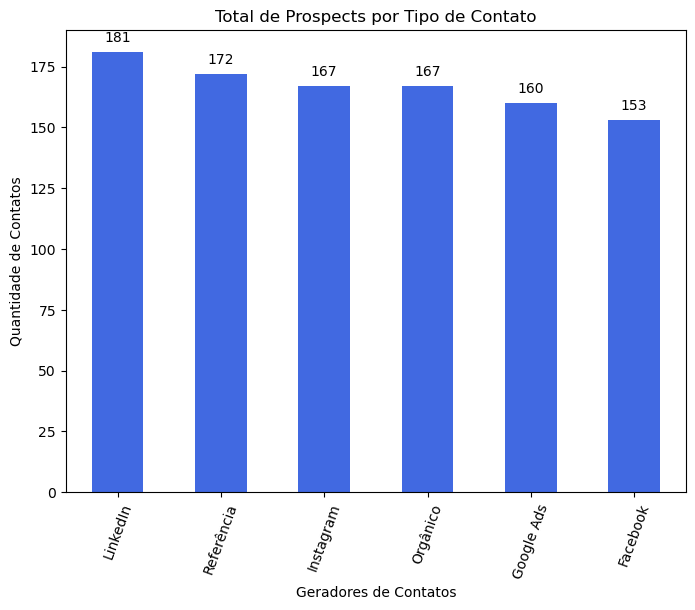

In [11]:
# Define o tamanho da figura do gráfico (largura=10, altura=8)
plt.figure(figsize=(8, 6))

# Conta o número de ocorrências de cada categoria na coluna "Fonte_Contato"
# Isso cria uma Série pandas com os valores únicos e suas contagens
grafico = dataset['Fonte_Contato'].value_counts()

# Cria um gráfico de barras usando os dados da contagem
# "kind='bar'" especifica que queremos um gráfico de barras
# "color='royalblue'" define a cor das barras para melhorar a visualização
ax = grafico.plot(kind='bar', color='royalblue')

# Define o título do gráfico
plt.title('Total de Prospects por Tipo de Contato')
# Define o rótulo do eixo X (categorias da "Fonte_Contato")
plt.xlabel("Geradores de Contatos")
# Define o rótulo do eixo Y (quantidade de contatos)
plt.ylabel("Quantidade de Contatos")
# Rotaciona os rótulos do eixo X em 70 graus para melhor legibilidade
plt.xticks(rotation=70)

# Adiciona rótulos numéricos no topo de cada barra para mostrar os valores
for p in ax.patches:  # Itera sobre todas as barras do gráfico
    ax.annotate(
        f"{p.get_height():.0f}",  # Obtém a altura da barra e exibe como número inteiro
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posiciona o texto no centro da barra
        ha='center',  # Alinha o texto horizontalmente no centro da barra
        va='bottom',  # Alinha o texto verticalmente acima da barra
        fontsize=10,  # Define o tamanho da fonte do texto
        xytext=(0, 5),  # Move o texto 5 pontos acima da barra para evitar sobreposição
        textcoords='offset points'  # Usa coordenadas relativas para melhor posicionamento
    )

# Exibe o gráfico na tela
plt.show()

**Análise da Participação dos Canais de Contato**

Ao analisar a distribuição dos contatos recebidos pela empresa, podemos observar a participação percentual de cada canal na geração de prospects:

- **LinkedIn**: 18,1%  
- **Referência**: 17,2%  
- **Instagram**: 16,7%  
- **Orgânico**: 16,7%  
- **Google Ads**: 16,0%  
- **Facebook**: 15,3%  

**Principais Observações:**
1. **LinkedIn lidera a captação de leads**, representando a maior fatia (18,1%). Isso pode indicar que os clientes que vêm dessa plataforma têm um perfil mais qualificado para o produto ou serviço da empresa.
   
2. **Referência também tem um peso significativo (17,2%)**, o que pode significar que indicações de clientes satisfeitos ou parceiros de negócio são uma fonte relevante para a empresa. Isso sugere a importância de manter um bom relacionamento com clientes atuais e incentivar programas de indicação.

3. **Instagram e tráfego orgânico têm um desempenho igual (16,7%)**, demonstrando a relevância das redes sociais e do SEO para atrair novos leads.

4. **Google Ads (16,0%) e Facebook (15,3%)** também desempenham um papel considerável na captação de clientes, mostrando que anúncios pagos são uma estratégia importante para a empresa.

**Próximos Passos:**
- **Analisar a taxa de conversão por canal**: Embora LinkedIn gere mais leads, será que também converte mais clientes em contratos? Identificar a relação entre origem do contato e taxa de fechamento ajudará na alocação estratégica de investimentos em marketing.
- **Entender o perfil de cada canal**: Diferentes canais podem atrair clientes com características distintas. Vale a pena cruzar os dados com atributos como orçamento disponível e tempo de resposta para verificar quais canais geram os leads mais qualificados.
- **Avaliar o custo-benefício**: Campanhas pagas (Google Ads, Facebook, LinkedIn) precisam ser analisadas sob a ótica do retorno sobre investimento (ROI). Se um canal tem um alto custo por lead, mas baixa conversão, pode não valer a pena manter o investimento.

In [12]:
dados_agrupados = dataset.groupby('Fonte_Contato')['Fechou_Contrato'].value_counts()
dados_agrupados

Fonte_Contato  Fechou_Contrato
Facebook       0                  115
               1                   38
Google Ads     0                  130
               1                   30
Instagram      0                  130
               1                   37
LinkedIn       0                  144
               1                   37
Orgânico       0                  120
               1                   47
Referência     0                  140
               1                   32
Name: count, dtype: int64

**Análise da Conversão por Fonte de Contato**

Os dados fornecidos mostram a quantidade de clientes que fecharam ou não contrato, segmentados por canal de aquisição. Vamos analisar os principais insights:

**Taxa de Conversão por Fonte de Contato:**
- **Facebook**: 24,8% (38 fechamentos em 153 contatos)
- **Google Ads**: 18,7% (30 fechamentos em 160 contatos)
- **Instagram**: 22,2% (37 fechamentos em 167 contatos)
- **LinkedIn**: 20,4% (37 fechamentos em 181 contatos)
- **Orgânico**: 28,2% (47 fechamentos em 167 contatos)
- **Referência**: 18,6% (32 fechamentos em 172 contatos)

**Principais Observações:**
1. **O tráfego orgânico tem a maior taxa de conversão (28,2%)**, indicando que clientes que chegam por busca espontânea já têm um maior nível de interesse e qualificação. Isso sugere que investir em estratégias de SEO pode gerar leads mais propensos a fechar contrato.

2. **Facebook tem uma conversão relativamente alta (24,8%)**, o que pode indicar que a estratégia de marketing nessa plataforma está atingindo o público certo.

3. **LinkedIn tem o maior volume de contatos, mas não lidera em conversão (20,4%)**, o que pode indicar que nem todos os leads dessa plataforma são qualificados. Pode ser necessário um filtro mais criterioso para melhorar a qualidade dos contatos vindos de lá.

4. **Google Ads e Referência têm as menores taxas de conversão (18,7% e 18,6%)**, o que pode indicar que os leads desses canais precisam de um processo de qualificação mais rigoroso antes de serem abordados pelos atendentes.

**Oportunidades para Otimização:**
- **Reforçar estratégias de SEO**: Como o tráfego orgânico gera a maior taxa de conversão, vale a pena investir mais em conteúdo e otimização para atrair leads qualificados.
- **Aprimorar filtros nos anúncios pagos**: Como Google Ads e Facebook geram muitos leads, mas com conversões variadas, ajustar os critérios de segmentação pode melhorar os resultados.
- **Focar em estratégias de retenção e indicações**: A taxa de conversão de referências poderia ser maior, pois clientes indicados geralmente já conhecem a empresa. Melhorar a experiência dos clientes pode ajudar a aumentar essa conversão.

### Calculando a Prevalência da Classe Positiva

**A prevalência da classe positiva** é a proporção de ocorrências do evento de interesse dentro de um conjunto de dados. No contexto de previsão de conversão de clientes, ela indica **quantos clientes fecharam contrato em relação ao total de prospects**.  

#### **Para que Serve?**  
- **Avaliação do Desequilíbrio de Classes**: Se a classe positiva for muito menor que a negativa, pode ser necessário balancear os dados para evitar viés no modelo preditivo.  
- **Métrica para Modelagem**: Em algoritmos de Machine Learning, uma classe muito rara pode exigir técnicas como reamostragem (oversampling/undersampling) ou ajuste de pesos.  
- **Tomada de Decisão Estratégica**: Se a taxa de conversão for muito baixa, estratégias de marketing e atendimento podem ser ajustadas para melhorar o fechamento de contratos.  

### Prevalência da Classe Positiva

A fórmula para calcular a **prevalência da classe positiva** é:

$$
\text{Prevalência} = \frac{\text{Número de ocorrências da classe positiva}}{\text{Total de observações}} \times 100
$$

Onde:
- **Classe positiva**: O evento de interesse (exemplo: clientes que fecharam contrato).
- **Total de observações**: O número total de registros no conjunto de dados.

Essa fórmula expressa a prevalência em **percentual (%)**, indicando a proporção da classe positiva em relação ao total.



In [13]:
# Função para calcular a prevalência da classe positiva (label = 1)
def calcula_prevalencia(y_atual):
    """
    Calcula a prevalência de casos positivos em um conjunto de dados binário.
    Parâmetros:
    y_atual (list ou array): Lista ou array contendo valores binários (0 e 1),
                             onde 1 representa um caso positivo.
    Retorno:
    float: A proporção de casos positivos em relação ao total de elementos.
    """    
    # Soma os valores de y_atual (onde 1 representa casos positivos) 
    # e divide pelo total de elementos para obter a proporção
    return sum(y_atual) / len(y_atual)

In [14]:
# Exibe a prevalência da classe positiva formatada com 3 casas decimais
print("Prevalência da classe positiva: %.3f" % calcula_prevalencia(dataset["Fechou_Contrato"].values))

Prevalência da classe positiva: 0.221


A **prevalência da classe positiva** de **0.221** significa que, dentro do conjunto de dados, aproximadamente **22,1%** dos exemplos pertencem à classe positiva.  

Como estamos lidando com um problema de previsão, como identificar clientes que fecharão um contrato, isso indica que **22,1% dos casos são positivos (clientes que fecham contrato), enquanto os outros 77,9% são negativos (clientes que não fecham contrato).**  

Esse valor pode ser útil para avaliar o balanceamento do dataset. Como a prevalência é muito baixa, será necessário lidar com um problema de **desbalanceamento de classes**, aplicando técnicas como **reestruturação dos dados (undersampling/oversampling), ajuste de pesos ou uso de métricas adequadas (AUC-ROC, F1-score)**.

## Etapa 5 - Engenharia de Atributos



Efetuaremos a binarização devido à necessidade de converter a variável **Fonte_Contato** para um formato numérico, garantindo que os modelos de aprendizado de máquina consigam interpretá-la corretamente.  

Além disso, a binarização antes da divisão dos dados evita **fuga de informações (data leakage)** e assegura que todas as categorias estejam presentes nos conjuntos de treino, validação e teste, mantendo a **consistência estrutural** e melhorando a **generalização do modelo**.  

A seguir, realizaremos esse processo para preparar os dados adequadamente.


In [15]:
# Criação de variáveis dummies para a coluna 'Fonte_Contato'
dados_dummie_Fonte_Contato = pd.get_dummies(dataset.Fonte_Contato)   # Gera variáveis dummies
dados_dummie_Fonte_Contato = dados_dummie_Fonte_Contato.astype(int)  # Converte os valores para inteiros
dados_dummie_Fonte_Contato                                           # Exibe o DataFrame resultante

,Facebook,Google Ads,Instagram,LinkedIn,Orgânico,Referência
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,1,0
...,...,...,...,...,...,...
995,0,1,0,0,0,0
996,0,0,0,0,0,1
997,0,0,0,0,0,1
998,0,0,0,1,0,0


Justificativa para a Binarização Antes da Divisão dos Dados

A binarização das variáveis categóricas antes da separação dos conjuntos de **treino, validação e teste** é uma etapa fundamental no processamento de dados para aprendizado de máquina. Essa prática garante:

**Evitar Data Leakage**  
Transformar os dados antes da divisão impede que informações do conjunto de validação ou teste influenciem a codificação, mantendo a integridade do modelo.  

Consistência Estrutural**  
Se binarizarmos após a separação, categorias presentes no treino podem estar ausentes no teste, prejudicando a generalização do modelo.  

**Compatibilidade com Modelos**  
Algoritmos de machine learning não lidam bem com variáveis categóricas, exigindo conversão para um formato numérico (como One-Hot Encoding ou Label Encoding) antes do treinamento.  

**Conclusão**: Binarizar os dados antes da divisão assegura um modelo **mais robusto, generalizável e livre de vazamento de informações**.

In [16]:
dataset_concatenado = pd.concat([dados_dummie_Fonte_Contato, dataset],axis=1)
dataset_concatenado

,Facebook,Google Ads,Instagram,LinkedIn,Orgânico,Referência,ID_Cliente,Fonte_Contato,Interesse_Produto,Orçamento_Disponível,Tempo_Resposta,Experiência_Setor,Score_Qualificação,Fechou_Contrato
0,0,0,1,0,0,0,1,Instagram,4,7647,1435,1,68,1
1,0,0,0,1,0,0,2,LinkedIn,5,4951,1224,7,12,0
2,0,0,0,0,0,1,3,Referência,3,15843,315,11,86,1
3,0,0,0,0,0,1,4,Referência,5,14135,266,4,57,1
4,0,0,0,0,1,0,5,Orgânico,5,6459,410,6,49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,996,Google Ads,2,3317,564,2,87,0
996,0,0,0,0,0,1,997,Referência,1,15596,676,14,86,0
997,0,0,0,0,0,1,998,Referência,1,19380,1146,3,21,0
998,0,0,0,1,0,0,999,LinkedIn,4,5799,1408,14,1,0


In [17]:
# Remove as colunas 'ID_Cliente' e 'Fonte_Contato' do dataset.
# O parâmetro axis=1 indica que estamos removendo colunas (e não linhas).
# O parâmetro inplace=True aplica a remoção diretamente no dataset, sem necessidade de reatribuição.
dataset_concatenado.drop(['ID_Cliente', 'Fonte_Contato'], axis=1, inplace=True)

## Etapa 6 - Divisão dos Dados em Treino, Validação e Teste

---

A divisão dos dados é essencial no treinamento de modelos de aprendizado de máquina, garantindo que o modelo aprenda, seja ajustado e avaliado corretamente.  

- **Conjunto de treinamento**: usado para treinar o algoritmo, por isso deve conter a maior parte dos dados, permitindo que o modelo aprenda padrões significativos.  
- **Conjunto de validação**: utilizado para ajustar hiperparâmetros e comparar diferentes abordagens, ajudando a escolher a configuração com melhor desempenho.  
- **Conjunto de teste**: reservado para avaliar a precisão final do modelo, garantindo que ele generalize bem para novos dados.  

A proporção de divisão pode variar conforme o tamanho do conjunto de dados. Algumas configurações comuns incluem **50/25/25, 60/20/20 e 70/15/15** para treinamento, validação e teste, respectivamente. No entanto, para conjuntos de dados extremamente grandes (com centenas de milhões de registros), é possível utilizar divisões como **98/1/1**, garantindo que o modelo tenha um volume suficiente de dados para aprender sem comprometer a validação e o teste.  

---

In [18]:
# Definindo a variável alvo (y) - Suponha que a coluna 'Fechou_Contrato' seja a variável que queremos prever
y = dataset_concatenado['Fechou_Contrato']  # O alvo

# Definindo as features (X) - Todas as colunas, exceto a variável alvo
X = dataset_concatenado.drop(columns=['Fechou_Contrato'])  # As features (atributos)

In [19]:
# Primeira divisão: separa 70% dos dados para treino e 30% para validação/teste.
# O parâmetro stratify=y garante que a proporção das classes seja mantida em cada conjunto.
# O parâmetro random_state=42 mantém a reprodutibilidade dos resultados.
dados_x_treino, dados_x_temporario, dados_y_treino, dados_y_temporario = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Segunda divisão: dos 30% restantes, divide igualmente entre validação (15%) e teste (15%).
# O parâmetro stratify=dados_y_temporario mantém a mesma distribuição das classes nos conjuntos de validação e teste.
dados_x_validacao, dados_x_teste, dados_y_validacao, dados_y_teste = train_test_split(dados_x_temporario, dados_y_temporario, test_size=0.5, stratify=dados_y_temporario, random_state=42)

---

Esse código divide o dataset em três partes:  
- **70% para treino**
- **15% para validação**
- **15% para teste**  
---

In [20]:
# Imprime a quantidade de amostras no conjunto de teste e a prevalência de fechamento de contrato nesse conjunto
# A função len(dados_teste) retorna o número total de registros em dados_teste
# A função calcula_prevalencia() recebe a coluna "Fechou_Contrato" convertida em um array e calcula a prevalência
# O formato da string (%d para inteiro e %.3f para float) garante uma saída legível
print("Teste(n = %d): %.3f" % (len(dados_x_teste), calcula_prevalencia(dados_y_teste.values)))
# Imprime a quantidade de amostras no conjunto de validação e a prevalência de fechamento de contrato nesse conjunto
# Semelhante ao código anterior, mas aplicado ao conjunto de validação (dados_validacao)
print("Validação(n = %d): %.3f" % (len(dados_x_validacao), calcula_prevalencia(dados_y_validacao.values)))
# Imprime a quantidade de amostras no conjunto de treinamento e a prevalência de fechamento de contrato nesse conjunto
# Aqui, a função calcula a métrica para os dados de treino (dados_treino), que são usados para ajustar o modelo
print("Treinamento(n = %d): %.3f" % (len(dados_x_treino), calcula_prevalencia(dados_y_treino.values)))

Teste(n = 150): 0.220
Validação(n = 150): 0.220
Treinamento(n = 700): 0.221


In [21]:
# Imprime a quantidade total de amostras no conjunto dataset_concatenado
# len(dataset_concatenado) retorna o número total de registros no conjunto de dados amostrado
print('Todas as amostras (n = %d)' % len(dataset_concatenado))

# Verifica se a quantidade total de amostras em sample_dados é exatamente igual 
# à soma dos conjuntos de teste, treino e validação.
# Se os tamanhos não coincidirem, a execução do código será interrompida e uma mensagem de erro será exibida.
assert len(dataset_concatenado) == (len(dados_x_teste) + len(dados_x_treino) + len(dados_x_validacao)), "Algo saiu errado"

Todas as amostras (n = 1000)


In [22]:
dados_x_treino.head(2)

,Facebook,Google Ads,Instagram,LinkedIn,Orgânico,Referência,Interesse_Produto,Orçamento_Disponível,Tempo_Resposta,Experiência_Setor,Score_Qualificação
514,0,0,0,0,0,1,4,17843,1110,12,0
643,0,0,0,0,0,1,3,11671,548,11,43


In [23]:
dados_y_treino.head(2)

514    0
643    0
Name: Fechou_Contrato, dtype: int64

In [24]:
dataset_concatenado["Fechou_Contrato"].value_counts()

Fechou_Contrato
0    779
1    221
Name: count, dtype: int64

---

### **Balanceamento do Conjunto de Dados para Melhor Desempenho do Modelo**  

Para evitar que nosso modelo aprenda de forma tendenciosa e classifique incorretamente as amostras como pertencentes à classe majoritária, é essencial equilibrar o conjunto de dados.  

No nosso caso, a variável **"Fechou_Contrato"** está desbalanceada:  
- **779 amostras** pertencem à classe **0** (não fechou contrato).  
- **221 amostras** pertencem à classe **1** (fechou contrato).  

Se treinarmos um modelo com esse conjunto de dados sem ajustes, ele tenderá a favorecer a classe majoritária (**0 - não fechou contrato**), resultando em previsões enviesadas e baixo desempenho na identificação de clientes que realmente fechariam contrato.  

Para mitigar esse problema, aplicamos o método de **subamostragem** (undersampling), onde selecionamos aleatoriamente um subconjunto das amostras da classe majoritária para equilibrar as proporções entre as classes. Dessa forma, garantimos que o modelo aprenda de maneira mais representativa e justa, melhorando sua capacidade preditiva.  

---

## Etapa 7 - Balanceamento de Classe

Aplicamos balanceamento de classe somente nos dados de treino.

In [25]:
# Cria uma máscara booleana onde True indica que a amostra pertence à classe positiva (Fechou_Contrato = 1), ou seja, clientes que fecharam contrato.
linha_positiva = dados_y_treino == 1  

**Por que devemos aplicar o balanceamento somente nos dados de treino?**

O balanceamento dos dados é uma técnica fundamental para evitar que o modelo aprenda de maneira enviesada em conjuntos de dados desbalanceados. No entanto, **esse balanceamento deve ser aplicado apenas nos dados de treino**, e há razões importantes para isso:

1. **Evitar Viés na Avaliação do Modelo**  
   - O conjunto de **teste e validação** deve representar a **realidade dos dados** que o modelo encontrará no mundo real.  
   - Se aplicarmos o balanceamento nesses conjuntos, estaríamos artificialmente alterando a distribuição dos dados, tornando os resultados da avaliação irreais.  
   - A métrica final precisa refletir o desempenho do modelo em um cenário desbalanceado, como o que ocorrerá na prática.

2. **Garantir Generalização Correta**  
   - Se balancearmos os dados de teste e validação, o modelo pode se adaptar a um cenário que **não existe** no ambiente real.  
   - Isso pode levar a métricas **infladas** ou **enganosas**, fazendo parecer que o modelo está melhor do que realmente é.

3. **Treinar um Modelo Justo e Representativo**  
   - O objetivo do balanceamento no **treino** é permitir que o modelo aprenda a reconhecer padrões em ambas as classes, mesmo que uma seja muito menor.  
   - Porém, a avaliação deve ser feita com os dados **originais**, sem modificação, para verificar se o modelo consegue lidar com a desproporção natural entre as classes.

4. **Evitar Overfitting ao Balanceamento**  
   - Se balancearmos todo o conjunto de dados, o modelo pode ficar **viciado** em uma distribuição artificial e ter dificuldades em prever corretamente novas amostras no ambiente real.

**Conclusão**
Aplicar o balanceamento **apenas nos dados de treino** garante que o modelo aprenda de forma justa, sem favorecer a classe majoritária, mas ainda seja avaliado em um contexto realista. Isso resulta em uma melhor estimativa de sua capacidade de generalização e desempenho prático.



In [26]:
dados_x_treino_positivo = dados_x_treino.loc[linha_positiva]  # Dados da classe positiva
dados_x_treino_negativo = dados_x_treino.loc[~linha_positiva] # Dados da classe negativa
dados_y_treino_positivo = dados_y_treino.loc[linha_positiva]  # Rótulos da classe positiva
dados_y_treino_negativo = dados_y_treino.loc[~linha_positiva] # Rótulos da classe negativa

In [27]:
# Calcula o tamanho mínimo entre as quantidades de amostras positivas e negativas no conjunto de treino
# `len(dados_treino_positivo)`: Número de amostras onde Fechou_Contrato = 1 (clientes que fecharam contrato)
# `len(dados_treino_negativo)`: Número de amostras onde Fechou_Contrato = 0 (clientes que não fecharam contrato)
# `np.min([...])` retorna o menor valor entre os dois, garantindo um número equilibrado de amostras para balanceamento
valor_minimo = np.min([len(dados_x_treino_positivo), len(dados_x_treino_negativo)])

In [28]:
# Realizando o balanceamento via undersampling
dados_x_treino_balanceado = pd.concat([
    dados_x_treino_positivo.sample(n=valor_minimo, random_state=64),
    dados_x_treino_negativo.sample(n=valor_minimo, random_state=64)
], axis=0).reset_index(drop=True)

In [29]:
dados_y_treino_balanceado = pd.concat([
    dados_y_treino_positivo.sample(n=valor_minimo, random_state=64),
    dados_y_treino_negativo.sample(n=valor_minimo, random_state=64)
], axis=0).reset_index(drop=True)

In [30]:
# Embaralhando os dados balanceados
dados_x_treino_balanceado = dados_x_treino_balanceado.sample(frac=1, random_state=64).reset_index(drop=True)
dados_y_treino_balanceado = dados_y_treino_balanceado.sample(frac=1, random_state=64).reset_index(drop=True)

In [31]:
# Exibindo o resultado
print("Distribuição das classes após balanceamento:")
print(dados_y_treino_balanceado.value_counts(normalize=True))

Distribuição das classes após balanceamento:
Fechou_Contrato
0    0.5
1    0.5
Name: proportion, dtype: float64


In [32]:
# Imprime o número total de amostras no conjunto de treino balanceado e a prevalência da classe positiva
# `len(dados_treino_final)`: Exibe a quantidade total de amostras no conjunto de treino final após o balanceamento
# `calcula_prevalencia(dados_treino_final.Fechou_Contrato.values)`: Calcula a taxa de prevalência da classe positiva (Fechou_Contrato = 1)
# "%.3f"`: Formata a saída da prevalência para três casas decimais, garantindo melhor legibilidade dos resultados
print("Balanceamento em Treino(n = %d): %.3f" % (len(dados_x_treino_balanceado), calcula_prevalencia(dados_y_treino_balanceado.values)))

Balanceamento em Treino(n = 310): 0.500


**Análise do Resultado**  
O resultado indica que, após o balanceamento, o conjunto de treino contém **314 amostras**, e a **prevalência da classe positiva** (`Fechou_Contrato = 1`) é **0.500** (50%).  

**Resumo**  
O balanceamento foi bem-sucedido, garantindo que ambas as classes tenham a **mesma quantidade de amostras** no treino. Isso evita que o modelo favoreça a classe majoritária e melhora a qualidade das previsões.

### Etapa 7.1 Criando as Matrizes X e Y

In [33]:
print('Shape dos dados de treino:', dados_x_treino_balanceado.shape, dados_y_treino_balanceado.shape)
print('Shape dos dados de validação:', dados_x_validacao.shape, dados_y_validacao.shape)

Shape dos dados de treino: (310, 11) (310,)
Shape dos dados de validação: (150, 11) (150,)


## **Etapa 8 - Padronização**



A padronização no pré-processamento de dados é uma técnica essencial na construção de modelos de classificação, além de ser amplamente utilizada em diversos outros tipos de modelos de machine learning. Essa etapa desempenha um papel crucial por vários motivos:

---

**Ajuste da Escala dos Dados**  
Os conjuntos de dados frequentemente contêm variáveis em escalas muito diferentes. Por exemplo, um dataset pode incluir a **idade dos indivíduos** (variando entre 0 e 100 anos) e seus **salários** (que podem variar de milhares a dezenas de milhares).  
- Modelos de machine learning podem, involuntariamente, atribuir mais peso às variáveis com valores numéricos maiores, simplesmente por causa da diferença de magnitude.  
- Isso pode levar a um **desequilíbrio na importância das variáveis**, impactando negativamente o desempenho do modelo.  
- A padronização resolve esse problema ao transformar todas as variáveis para a mesma escala.

---

**Aceleração da Convergência**  
Muitos algoritmos de machine learning, especialmente aqueles que utilizam **gradiente descendente** como método de otimização (como regressão logística e redes neurais), beneficiam-se diretamente da padronização.  
- Quando os dados não estão padronizados, o gradiente descendente pode ter dificuldades em encontrar a solução ótima, pois os pesos ajustam-se de maneira desproporcional.  
- A padronização garante que as atualizações dos pesos aconteçam de forma mais homogênea, resultando em uma **convergência mais rápida e eficiente**.

---

**Melhor Interpretabilidade dos Modelos**  
A padronização também pode facilitar a interpretação dos resultados, especialmente em modelos estatísticos e de aprendizado de máquina que utilizam coeficientes para medir a importância das variáveis.  
- Em modelos lineares, como regressão logística, os coeficientes refletem o impacto de cada variável na previsão.  
- Quando todas as variáveis estão na mesma escala, é possível compará-las diretamente, tornando a **análise mais intuitiva e informativa**.  

---

In [34]:
# Cria uma instância do objeto StandardScaler, que será usado para padronizar as características
# O StandardScaler ajusta os dados para ter média 0 e desvio padrão 1, o que é útil para muitos algoritmos de aprendizado de máquina
scaler = StandardScaler()

In [35]:
# Ajusta o scaler aos dados de treino (X_treino) para calcular a média e o desvio padrão de cada característica
# Essas estatísticas serão usadas posteriormente para padronizar os dados
scaler.fit(dados_x_treino_balanceado)

StandardScaler()

In [36]:
# Salva o objeto em disco e carrega para usamos adiante
scalerfile = 'scaler.sav'

In [37]:
# Salva o objeto 'scaler' em um arquivo binário usando o módulo pickle
# O arquivo será salvo com o nome especificado em 'scalerfile', no modo de escrita binária ('wb')
pickle.dump(scaler, open(scalerfile, 'wb'))

# Carrega o objeto 'scaler' de um arquivo binário usando o módulo pickle
# O arquivo a ser carregado é o especificado em 'scalerfile', no modo de leitura binária ('rb')
scaler = pickle.load(open(scalerfile, 'rb'))

In [38]:
# Aplica a padronização em nossas matrizes de dados
# Aplica a transformação do scaler aos dados de treino (X_treino) para padronizar as características
# O 'transform' usa as estatísticas calculadas previamente pelo 'fit' (média e desvio padrão)
X_treino_padronizado = scaler.transform(dados_x_treino_balanceado)

In [39]:
# Aplica a transformação do scaler aos dados de validação (X_valid) para padronizar as características
# O 'transform' usa as mesmas estatísticas de 'X_treino' para garantir a consistência entre os conjuntos
X_validacao_padronizado = scaler.transform(dados_x_validacao)

## Etapa 9 - Modelagem Preditiva

In [40]:
# Função para calcular a especificidade de um modelo de classificação
# A especificidade mede a capacidade do modelo de identificar corretamente os casos negativos (classe 0)
# Fórmula da especificidade: TN / (TN + FP), onde:
# - TN (True Negative) = Verdadeiros negativos (preditos corretamente como 0)
# - FP (False Positive) = Falsos positivos (preditos erroneamente como 1)
# - A especificidade indica quantos dos casos negativos foram corretamente identificados

# Parâmetros:
# - y_atual: vetor com os rótulos reais (0 ou 1)
# - y_predicao: vetor com as previsões do modelo (valores contínuos entre 0 e 1, antes do limiar)
# - thresh: limiar que define a classificação (por exemplo, 0.5 para um modelo binário)
def calcula_especificidade(y_atual, y_predicao, thresh):
    
    # Identifica os casos previstos como negativos (0), ou seja, quando a previsão é menor que o limiar
    negativos_preditos = y_predicao < thresh  
    
    # Identifica os casos reais negativos (0)
    negativos_reais = y_atual == 0  
    
    # Conta os verdadeiros negativos (casos em que o modelo previu 0 e o rótulo real também era 0)
    verdadeiros_negativos = sum(negativos_preditos & negativos_reais)  

    # Conta o total de casos realmente negativos no conjunto de dados
    total_negativos = sum(negativos_reais)  

    # Calcula a especificidade (taxa de verdadeiros negativos sobre o total de negativos reais)
    return verdadeiros_negativos / total_negativos

In [41]:
# Função para calcular e imprimir métricas de avaliação de um modelo de classificação
# Essa função recebe os rótulos reais (y_atual), as previsões do modelo (y_predicao) e um limiar (thresh) 
# e calcula diversas métricas importantes para avaliar a performance do modelo.

# Parâmetros:
# - y_atual: Vetor com os rótulos reais (valores 0 ou 1).
# - y_predicao: Vetor com os valores preditos pelo modelo (probabilidades entre 0 e 1 antes da decisão final).
# - thresh: Limiar de decisão que define se uma previsão será classificada como 0 ou 1 (exemplo: 0.5).

def imprime_retorna_metrica(y_atual, y_predicao, thresh):

    # Calcula a AUC (Área sob a curva ROC)
    # A AUC mede a capacidade do modelo de distinguir entre as classes positiva e negativa.
    # Quanto mais próximo de 1, melhor o modelo.
    auc = roc_auc_score(y_atual, y_predicao)

    # Calcula a acurácia do modelo
    # A acurácia representa a proporção de previsões corretas entre todas as previsões feitas.
    # O resultado é um valor entre 0 e 1, onde 1 indica todas as previsões corretas.
    accuracy = accuracy_score(y_atual, (y_predicao > thresh))

    # Calcula o recall (sensibilidade ou taxa de verdadeiros positivos)
    # Mede a capacidade do modelo de identificar corretamente os casos positivos.
    # Fórmula: Recall = TP / (TP + FN)
    recall = recall_score(y_atual, (y_predicao > thresh))

    # Calcula a precisão (proporção de positivos preditos corretamente)
    # Mede a exatidão das previsões positivas feitas pelo modelo.
    # Fórmula: Precisão = TP / (TP + FP)
    precision = precision_score(y_atual, (y_predicao > thresh))

    # Calcula a especificidade (taxa de verdadeiros negativos)
    # Mede a capacidade do modelo de identificar corretamente os casos negativos.
    # Fórmula: Especificidade = TN / (TN + FP)
    specificity = calcula_especificidade(y_atual, y_predicao, thresh)

    # Imprime os resultados das métricas calculadas, formatando os valores com 3 casas decimais
    print('AUC: %.3f' % auc)
    print('Acurácia: %.3f' % accuracy)
    print('Recall: %.3f' % recall)
    print('Precisão: %.3f' % precision)
    print('Especificidade: %.3f' % specificity)
    print(' ')  # Linha em branco para facilitar a leitura
    
    # Retorna as métricas calculadas
    return auc, accuracy, recall, precision, specificity

As métricas acima são amplamente utilizadas para avaliar o desempenho de modelos de classificação em machine learning. Cada uma fornece informações distintas sobre a qualidade das previsões do modelo.  

**AUC (Área sob a Curva ROC)**  
A AUC representa a área sob a curva ROC, que avalia o desempenho do modelo em diferentes limiares de classificação. A curva ROC exibe a relação entre a taxa de verdadeiros positivos (sensibilidade) e a taxa de falsos positivos (1 - especificidade). O valor da AUC varia entre 0 e 1, onde um modelo com AUC igual a 1 realiza classificações perfeitas, enquanto um modelo com AUC de 0.5 não tem desempenho melhor do que uma escolha aleatória.  

**Acurácia**  
A acurácia indica a proporção de previsões corretas em relação ao total de amostras analisadas. É calculada como a soma de verdadeiros positivos e verdadeiros negativos dividida pelo total de casos. Embora seja uma métrica útil para medir a eficácia geral do modelo, pode ser enganosa quando os dados estão desbalanceados, pois pode dar uma falsa impressão de bom desempenho caso uma classe seja muito mais frequente que a outra.  

**Recall (Sensibilidade ou Taxa de Verdadeiros Positivos)**  
O recall mede a proporção de exemplos positivos corretamente identificados pelo modelo. É calculado dividindo os verdadeiros positivos pelo total de exemplos que realmente pertencem à classe positiva. Essa métrica é importante quando a identificação correta dos casos positivos é essencial, como em diagnósticos médicos, onde a falha em detectar um caso positivo pode ter consequências graves.  

**Precisão**  
A precisão mede a proporção de previsões positivas que realmente correspondem à classe positiva. É calculada como o número de verdadeiros positivos dividido pela soma de verdadeiros positivos e falsos positivos. Uma alta precisão significa uma menor taxa de falsos positivos, o que é essencial em aplicações onde classificações incorretas podem gerar custos elevados, como em fraudes bancárias.  

**Especificidade**  
A especificidade avalia a proporção de exemplos negativos corretamente identificados. É calculada dividindo os verdadeiros negativos pelo total de exemplos que pertencem à classe negativa. Essa métrica é relevante em cenários onde minimizar falsos positivos é crítico, como no controle de qualidade em processos industriais. No scikit-learn, a especificidade não é fornecida diretamente, mas pode ser calculada a partir da matriz de confusão ou por meio de uma função personalizada.

In [42]:
#Como os dados de treinamento foram equilibrados, vamos definir um limiar de 0,5 para classificar uma amostra prevista como positiva.
thresh = 0.5

### **Versão 1 - Modelos Lineares**  



---

**Versão 1: Modelo Linear para Classificação – Regressão Logística**  

Na primeira versão do nosso modelo, utilizaremos a **Regressão Logística**, um algoritmo linear amplamente empregado em **tarefas de classificação binária**.  

Esse método é usado para prever um **resultado binário**, ou seja, ele decide entre duas possíveis categorias, como **sim ou não**, **verdadeiro ou falso**, **sucesso ou fracasso**.  

A regressão logística funciona calculando a **probabilidade** de um evento ocorrer com base nas características observadas nos dados. Por exemplo, podemos utilizá-la para prever se um cliente realizará uma compra, considerando seu histórico de compras e outros atributos relevantes.  

Além de ser um modelo intuitivo e fácil de interpretar, a regressão logística é **robusta e eficiente**, sendo amplamente utilizada em problemas como **diagnóstico médico, análise de crédito e detecção de fraudes**.  

---


In [43]:
# Construção do modelo
# Cria o classificador (objeto) de Regressão Logística
# max_iter: define o número máximo de iterações para o processo de ajuste (500 para garantir convergência)
# random_state: define a semente aleatória para tornar o resultado reprodutível
# Importa o modelo de Regressão Logística
lr = LogisticRegression(max_iter=500, random_state=142)
# Treina o modelo usando os dados de treino normalizados (X_treino_tf) e os rótulos (y_treino)
modelo_regressao_logistica = lr.fit(X_treino_padronizado, dados_y_treino_balanceado)
# Previsões para os dados de treino e validação
# A função predict_proba retorna as probabilidades de cada classe. [:, 1] seleciona a probabilidade da classe 1 (positiva)
y_train_preds = modelo_regressao_logistica.predict_proba(X_treino_padronizado)[:, 1]  # Probabilidades do conjunto de treino
y_valid_preds = modelo_regressao_logistica.predict_proba(X_validacao_padronizado)[:, 1]  # Probabilidades do conjunto de validação
# Imprime um título para indicar que o modelo de Regressão Logística está sendo avaliado
print('\nRegressão Logística\n')
# Avaliação do modelo no conjunto de treino
print('Treinamento:\n')
# Chama a função dsa_print_report para calcular e exibir métricas de avaliação no conjunto de treino
# As métricas retornadas incluem:
# - AUC (Área sob a curva ROC)
# - Acurácia (acc)
# - Recall (rec)
# - Precisão (prec)
# - Especificidade (spec)
v1_train_auc, v1_train_acc, v1_train_rec, v1_train_prec, v1_train_spec = imprime_retorna_metrica(
    dados_y_treino_balanceado,  # Rótulos verdadeiros do conjunto de treino
    y_train_preds,  # Previsões do modelo para o conjunto de treino
    thresh  # Limite de decisão para classificação (threshold)
)

# Avaliação do modelo no conjunto de validação
print('Validação:\n')
# Chama a função dsa_print_report para calcular e exibir métricas de avaliação no conjunto de validação
v1_valid_auc, v1_valid_acc, v1_valid_rec, v1_valid_prec, v1_valid_spec = imprime_retorna_metrica(
    dados_y_validacao,  # Rótulos verdadeiros do conjunto de validação
    y_valid_preds,  # Previsões do modelo para o conjunto de validação
    thresh  # Limite de decisão para classificação (threshold)
)


Regressão Logística

Treinamento:

AUC: 0.957
Acurácia: 0.881
Recall: 0.903
Precisão: 0.864
Especificidade: 0.858
 
Validação:

AUC: 0.912
Acurácia: 0.820
Recall: 0.909
Precisão: 0.556
Especificidade: 0.795
 


### Versão 2  - Modelos Probabilísticos

---

**Versão 2: Algoritmo Probabilístico - Gaussian Naive Bayes**  

Na segunda versão do nosso modelo, utilizaremos o **Gaussian Naive Bayes**, um algoritmo probabilístico baseado no **Teorema de Bayes**.  

O Gaussian Naive Bayes assume que os atributos de entrada seguem uma distribuição **normal (gaussiana)** e que todas as características são **independentes entre si**. Embora essa suposição raramente seja verdadeira na prática, ela simplifica os cálculos e torna o modelo computacionalmente eficiente.  

Esse algoritmo é especialmente útil em **problemas de classificação** onde as variáveis preditoras são contínuas e aproximadamente normais, como em **classificação de textos**, **diagnósticos médicos** e **reconhecimento de padrões**.  

O funcionamento do Gaussian Naive Bayes consiste em calcular a **probabilidade condicional** de cada classe com base nos atributos de entrada e, em seguida, atribuir a classe com **maior probabilidade** à nova instância. Apesar de sua simplicidade, esse modelo pode alcançar bons resultados em diversas aplicações, especialmente quando há um grande volume de dados.  

---


In [49]:
# Construção do modelo
# Cria o classificador Gaussian Naive Bayes
# O GaussianNB é um modelo probabilístico que assume que as características seguem uma distribuição normal (gaussiana).
nb = GaussianNB()

# Treina o modelo usando os dados de treino já padronizados e balanceados
# O método .fit(X, y) ajusta o modelo aos dados de treinamento
modelo_Gaussian = nb.fit(X_treino_padronizado, dados_y_treino_balanceado)

# Previsões do modelo
# Gera previsões para o conjunto de treino e validação
# O método predict_proba(X) retorna as probabilidades de cada classe (0 e 1)
# [:, 1] seleciona apenas a probabilidade associada à classe positiva (Fechou_Contrato = 1)
y_train_preds = modelo_Gaussian.predict_proba(X_treino_padronizado)[:, 1]        # Probabilidades do conjunto de treino
y_valid_preds = modelo_Gaussian.predict_proba(X_validacao_padronizado)[:, 1]     # Probabilidades do conjunto de validação

# Avaliação do modelo
# Exibe um título para indicar que o modelo Gaussian Naive Bayes está sendo avaliado
print('\nAvaliação do Gaussian Naive Bayes\n')
# Avaliação no conjunto de treino
print('Treinamento:\n')

# Chama a função imprime_retorna_metrica para calcular e exibir métricas de avaliação no conjunto de treino
# As métricas retornadas incluem:
# - AUC (Área sob a curva ROC): Mede a capacidade do modelo de separar as classes.
# - Acurácia (Accuracy): Percentual de previsões corretas.
# - Recall (Sensibilidade): Proporção de casos positivos corretamente identificados.
# - Precisão (Precision): Proporção de previsões positivas corretas.
# - Especificidade: Mede a capacidade do modelo de identificar corretamente os casos negativos.

v2_train_auc, v2_train_acc, v2_train_rec, v2_train_prec, v2_train_spec = imprime_retorna_metrica(
    dados_y_treino_balanceado,  # Rótulos reais do conjunto de treino
    y_train_preds,              # Probabilidades preditas pelo modelo para o conjunto de treino
    thresh                      # Limiar de decisão para classificação
)

# Avaliação no conjunto de validação
print('Validação:\n')

# Chama a função imprime_retorna_metrica para calcular e exibir métricas de avaliação no conjunto de validação
v2_valid_auc, v2_valid_acc, v2_valid_rec, v2_valid_prec, v2_valid_spec = imprime_retorna_metrica(
    dados_y_validacao,  # Rótulos reais do conjunto de validação
    y_valid_preds,      # Probabilidades preditas pelo modelo para o conjunto de validação
    thresh              # Limiar de decisão para classificação
)


Avaliação do Gaussian Naive Bayes

Treinamento:

AUC: 0.989
Acurácia: 0.932
Recall: 0.942
Precisão: 0.924
Especificidade: 0.923
 
Validação:

AUC: 0.967
Acurácia: 0.887
Recall: 0.909
Precisão: 0.682
Especificidade: 0.880
 


### Versão 3  - Modelos de Árvore de Decisão e Boosting

---

**Versão 3: Modelo Baseado em Árvores de Decisão e Boosting – XGBoost**  

Nesta terceira versão, utilizaremos o **XGBoost (eXtreme Gradient Boosting)**, um algoritmo baseado em **árvores de decisão** que aplica a técnica de **boosting** para melhorar a precisão das previsões.  

O XGBoost constrói modelos de forma sequencial, onde cada nova árvore corrige os erros das anteriores. Esse processo dá mais peso às instâncias mais difíceis de prever, tornando o modelo mais preciso e robusto.  

Entre suas principais vantagens, o XGBoost se destaca pela **eficiência computacional**, sendo otimizado para processar grandes volumes de dados com rapidez e baixo consumo de memória. Além disso, ele é altamente **flexível**, permitindo o ajuste de diversos hiperparâmetros e oferecendo suporte para diferentes funções de perda, o que o torna adequado tanto para **classificação** quanto para **regressão**.  

Outro ponto importante é sua **capacidade de lidar com dados reais**, pois ele gerencia automaticamente **valores ausentes** e possui técnicas de **regularização** para reduzir o risco de sobreajuste. Essas características tornam o XGBoost uma das escolhas mais populares em competições de ciência de dados e aplicações industriais, devido à sua confiabilidade e desempenho.  

---

In [48]:
# Construção do modelo

# Cria o classificador XGBoost (XGBClassifier)
# O XGBoost é um algoritmo de boosting eficiente, conhecido por seu desempenho em tarefas de classificação e regressão
# Importa o classificador XGBoost
xgbc = XGBClassifier()

# Treina o modelo usando os dados de treino normalizados (X_treino_tf) e os rótulos (y_treino)
modelo_XGBoost = xgbc.fit(X_treino_padronizado, dados_y_treino_balanceado)
# Previsões do modelo
# Gera previsões para o conjunto de treino e validação
# O método predict_proba(X) retorna as probabilidades de cada classe (0 e 1)
# [:, 1] seleciona apenas a probabilidade associada à classe positiva (Fechou_Contrato = 1)
y_train_preds = modelo_XGBoost.predict_proba(X_treino_padronizado)[:, 1]        # Probabilidades do conjunto de treino
y_valid_preds = modelo_XGBoost.predict_proba(X_validacao_padronizado)[:, 1]     # Probabilidades do conjunto de validação

# Avaliação do modelo
# Exibe um título para indicar que o modelo Gaussian Naive Bayes está sendo avaliado
print('\nAvaliação do Gaussian Naive Bayes\n')
# Avaliação no conjunto de treino
print('Treinamento:\n')

# Chama a função imprime_retorna_metrica para calcular e exibir métricas de avaliação no conjunto de treino
# As métricas retornadas incluem:
# - AUC (Área sob a curva ROC): Mede a capacidade do modelo de separar as classes.
# - Acurácia (Accuracy): Percentual de previsões corretas.
# - Recall (Sensibilidade): Proporção de casos positivos corretamente identificados.
# - Precisão (Precision): Proporção de previsões positivas corretas.
# - Especificidade: Mede a capacidade do modelo de identificar corretamente os casos negativos.

v3_train_auc, v3_train_acc, v3_train_rec, v3_train_prec, v3_train_spec = imprime_retorna_metrica(
    dados_y_treino_balanceado,  # Rótulos reais do conjunto de treino
    y_train_preds,              # Probabilidades preditas pelo modelo para o conjunto de treino
    thresh                      # Limiar de decisão para classificação
)

# Avaliação no conjunto de validação
print('Validação:\n')

# Chama a função imprime_retorna_metrica para calcular e exibir métricas de avaliação no conjunto de validação
v3_valid_auc, v3_valid_acc, v3_valid_rec, v3_valid_prec, v3_valid_spec = imprime_retorna_metrica(
    dados_y_validacao,  # Rótulos reais do conjunto de validação
    y_valid_preds,      # Probabilidades preditas pelo modelo para o conjunto de validação
    thresh              # Limiar de decisão para classificação
)


Avaliação do Gaussian Naive Bayes

Treinamento:

AUC: 1.000
Acurácia: 1.000
Recall: 1.000
Precisão: 1.000
Especificidade: 1.000
 
Validação:

AUC: 0.962
Acurácia: 0.987
Recall: 0.939
Precisão: 1.000
Especificidade: 1.000
 


## Etapa 10 - Validação Cruzada

---

**Validação Cruzada: Garantindo a Generalização do Modelo**  

A **validação cruzada** é uma técnica utilizada para avaliar o desempenho de um modelo preditivo, garantindo sua capacidade de **generalização** para novos dados. Esse método ajuda a estimar como o modelo se comportará em dados que não foram utilizados durante o treinamento, reduzindo problemas como **overfitting**.  

O princípio da validação cruzada é dividir o conjunto de dados em partes menores: uma parte é usada para treinar o modelo (**dados de treinamento**) e outra para testá-lo (**dados de teste ou validação**). Esse processo é repetido várias vezes, com diferentes divisões, permitindo que todas as amostras sejam utilizadas tanto para treino quanto para teste.  

**Validação Cruzada k-Fold**  

Um dos métodos mais comuns de validação cruzada é a **k-fold cross-validation**. Nesse método, os dados são divididos aleatoriamente em **k subconjuntos** (ou *folds*) de tamanho semelhante. O modelo é treinado **k vezes**, sempre utilizando **k-1 folds** para treinamento e o fold restante para teste. Esse processo garante que cada amostra seja usada pelo menos uma vez como dado de teste, tornando a avaliação mais confiável.  

A principal vantagem da validação cruzada k-fold é proporcionar uma **estimativa mais precisa** do desempenho do modelo, especialmente em conjuntos de dados pequenos ou desbalanceados. Em comparação com uma simples divisão entre treino e teste, a validação cruzada faz melhor uso dos dados disponíveis, reduzindo a variabilidade nos resultados.  

**Aplicação no XGBoost (XGBClassifier)**  

Para realizar a **validação cruzada no Xtreme Gradient Boosting Classifier (XGBClassifier)**, podemos utilizar a função `cross_val_score` da biblioteca **scikit-learn**. Essa função avalia o modelo em diferentes divisões de treino e teste, permitindo obter uma estimativa mais robusta do seu desempenho antes da etapa final de treinamento.  

---


In [46]:
# Importa o classificador XGBoost
xgbc = XGBClassifier()

# Configuração da Validação Cruzada
# A validação cruzada é uma técnica usada para avaliar o desempenho do modelo de forma mais robusta.
# Em vez de dividir os dados apenas uma vez em treino e teste, ela divide os dados em várias partes (folds)
# e treina o modelo várias vezes, cada vez usando uma parte diferente para validação.

# Define o número de divisões (folds) para a validação cruzada
n_splits = 5  # O conjunto de treino será dividido em 5 partes iguais para validação cruzada

# Define a métrica usada para avaliar o desempenho do modelo em cada iteração
score = 'roc_auc'  # A métrica escolhida é a AUC (Área sob a Curva ROC), muito usada para classificadores binários

# Realiza a validação cruzada
# A função `cross_val_score` realiza o treinamento e teste do modelo `n_splits` vezes.
# Em cada iteração, um dos folds é usado como conjunto de validação e os demais como conjunto de treino.
# Dessa forma, o modelo é avaliado em diferentes subconjuntos dos dados, reduzindo a chance de overfitting.
cv_scores = cross_val_score(xgbc, X_treino_padronizado, dados_y_treino_balanceado, cv=n_splits, scoring=score)

# Exibe os resultados da validação cruzada
print(f"Validação Cruzada com {n_splits} divisões")

# Exibe os valores da métrica AUC obtidos em cada uma das iterações da validação cruzada
print(f"Score AUC em Cada Divisão: {cv_scores}")

# Calcula a média dos valores obtidos na validação cruzada
# Isso fornece uma visão geral do desempenho médio do modelo
print(f"Média de Score AUC: {np.mean(cv_scores)}")

Validação Cruzada com 5 divisões
Score AUC em Cada Divisão: [1.         1.         1.         0.99791883 1.        ]
Média de Score AUC: 0.9995837669094694


---

**Relatório de Validação Cruzada (5-Fold Cross-Validation)**  

**Objetivo da Validação Cruzada**  
A validação cruzada com **5 divisões (5-fold cross-validation)** foi utilizada para avaliar o desempenho do modelo, garantindo que ele possa generalizar bem para novos dados. O principal objetivo desse processo é reduzir a variabilidade dos resultados e evitar overfitting, testando o modelo em diferentes subconjuntos dos dados.  

**Métrica Utilizada: Área Sob a Curva ROC (AUC)**  
A métrica escolhida para avaliação foi a **Área Sob a Curva ROC (AUC - Area Under the Curve)**, que mede a capacidade do modelo de distinguir entre as classes positivas e negativas. Valores próximos de **1.0** indicam um desempenho excelente, enquanto valores próximos de **0.5** indicam desempenho semelhante a um classificador aleatório.  

---

**Resultados Obtidos**  

**Score AUC em Cada Divisão:**
- **1ª Divisão:** 1.0000  
- **2ª Divisão:** 1.0000  
- **3ª Divisão:** 1.0000  
- **4ª Divisão:** 0.9979  
- **5ª Divisão:** 1.0000  

**Média de Score AUC:**  
- **0.9996 (aproximadamente 99.96%)**  

---

**Análise dos Resultados**  

1. **Alto Desempenho do Modelo**  
   - O modelo apresentou **AUC = 1.0** em **quatro das cinco divisões**, indicando que nessas execuções ele conseguiu separar perfeitamente as classes positivas e negativas.  
   - Apenas na **4ª divisão** houve uma ligeira queda para **0.9979**, o que ainda representa um desempenho excelente.

2. **Baixa Variabilidade**  
   - A variação entre os folds foi mínima, com uma diferença de apenas **0.0021** entre o menor e o maior valor de AUC.  
   - Isso sugere que o modelo é estável e mantém um desempenho consistente em diferentes subconjuntos dos dados.

3. **Possível Indício de Overfitting**  
   - Resultados **perfeitamente altos** podem indicar que o modelo se ajustou **muito bem aos dados de treino**, mas isso pode levantar preocupações sobre **overfitting**.  
   - Caso o conjunto de dados seja pequeno ou muito bem separado entre classes, o modelo pode estar capturando padrões específicos que podem não generalizar tão bem para novos dados.

---
**Conclusão**  
- O modelo demonstrou **excelente desempenho** na validação cruzada, com uma **média de AUC de 0.9996**.  
- A **baixa variabilidade** sugere que o modelo é **estável** e capaz de classificar corretamente as instâncias em diferentes divisões dos dados.  
---

## Etapa 11 - Otimização de Hiperparâmetros com GridSearchCV

---

Para otimizar os hiperparâmetros do modelo XGBoost, é possível utilizar o **GridSearchCV** ou o **RandomizedSearchCV** da biblioteca scikit-learn. Essas ferramentas automatizam a busca por combinações ideais de hiperparâmetros, selecionando aquela que proporciona o melhor desempenho ao modelo.

A seguir, exemplificamos o uso do **GridSearchCV** para ajustar alguns hiperparâmetros do XGBoost. O **RandomizedSearchCV** segue um processo semelhante, mas testa um número fixo de combinações aleatórias, tornando-se uma alternativa mais eficiente quando o espaço de hiperparâmetros é muito amplo.

---

In [53]:
%%time   

# Define o classificador XGBoost
xgbc = XGBClassifier()

# Define o espaço de hiperparâmetros para a otimização
# O GridSearchCV irá testar todas as combinações possíveis desses valores para encontrar a melhor configuração
param_grid = {
    'max_depth': [3, 4, 5],             # Profundidade máxima das árvores de decisão (controla a complexidade do modelo)
    'learning_rate': [0.01, 0.1, 0.2],  # Taxa de aprendizado (define o tamanho dos passos dados na otimização)
    'n_estimators': [100, 200, 300],    # Número de árvores na floresta (quanto maior, melhor, mas pode aumentar overfitting)
    'subsample': [0.7, 0.8, 0.9]        # Fração de amostras usadas para treinar cada árvore (ajuda a reduzir overfitting)
}
# Configura o GridSearchCV para buscar os melhores hiperparâmetros
# cv=5 -> Faz validação cruzada com 5 divisões para avaliar cada conjunto de hiperparâmetros
# scoring='roc_auc' -> Usa a métrica AUC-ROC para selecionar os melhores parâmetros
# n_jobs=-1 -> Utiliza todos os processadores disponíveis para acelerar a busca
grid_search = GridSearchCV(xgbc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# Realiza a busca pelos melhores hiperparâmetros usando os dados de treino
grid_search.fit(X_treino_padronizado, dados_y_treino_balanceado)
# Recupera os melhores hiperparâmetros encontrados pelo GridSearchCV
best_params = grid_search.best_params_
# O melhor modelo encontrado pelo GridSearchCV (treinado com os melhores hiperparâmetros)
modelo_ajustado_hiperparametro = grid_search.best_estimator_

# Previsões usando o modelo otimizado
# A função predict_proba retorna um array de probabilidades para cada classe (classe 0 e classe 1)
# [:,1] seleciona apenas a probabilidade da classe positiva (classe 1)
y_traino_predicao_otimizada = modelo_ajustado_hiperparametro.predict_proba(X_treino_padronizado)[:, 1]    # Previsões no conjunto de treino
y_validacao_predicao_otimizada = modelo_ajustado_hiperparametro.predict_proba(X_validacao_padronizado)[:, 1]     # Previsões no conjunto de validação

# Exibe o título informando que este é o modelo otimizado do XGBoost
print('\nXtreme Gradient Boosting Classifier - Otimizado\n')
# Exibe os melhores hiperparâmetros encontrados pelo GridSearchCV
print('Melhores hiperparâmetros:', best_params)
# Avaliação do modelo otimizado nos dados de treino
print('\nTreinamento:\n')

v4_train_auc, v4_train_acc, v4_train_rec, v4_train_prec, v4_train_spec = imprime_retorna_metrica(
    dados_y_treino_balanceado,  # Rótulos reais do conjunto de treino
    y_train_preds,              # Probabilidades preditas pelo modelo para o conjunto de treino
    thresh                      # Limiar de decisão para classificação
)

# Avaliação no conjunto de validação
print('Validação:\n')

# Chama a função imprime_retorna_metrica para calcular e exibir métricas de avaliação no conjunto de validação
v4_valid_auc, v4_valid_acc, v4_valid_rec, v4_valid_prec, v4_valid_spec = imprime_retorna_metrica(
    dados_y_validacao,  # Rótulos reais do conjunto de validação
    y_valid_preds,      # Probabilidades preditas pelo modelo para o conjunto de validação
    thresh              # Limiar de decisão para classificação
)


Xtreme Gradient Boosting Classifier - Otimizado

Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

Treinamento:

AUC: 0.989
Acurácia: 0.932
Recall: 0.942
Precisão: 0.924
Especificidade: 0.923
 
Validação:

AUC: 0.967
Acurácia: 0.887
Recall: 0.909
Precisão: 0.682
Especificidade: 0.880
 
CPU times: total: 812 ms
Wall time: 1.85 s


## Etapa 12 - Seleção do Melhor Modelo de Machine Learning

In [54]:
# Cria um dataframe com as métricas calculadas
# Importa a biblioteca Pandas para criar um DataFrame com os resultados dos modelos
# O objetivo é organizar os valores obtidos para facilitar a análise comparativa
df_results = pd.DataFrame({

    # 🔹 'classificador': Nome dos modelos treinados
    # Cada modelo é representado por uma sigla:
    # RL - Regressão Logística
    # NB - Naive Bayes
    # XGB - XGBoost
    # XGB_O - XGBoost Otimizado (GridSearchCV)
    'classificador': ['RL', 'RL', 'NB', 'NB', 'XGB', 'XGB', 'XGB_O', 'XGB_O'],

    # 'data_set': Define se os resultados correspondem ao conjunto de treino ou validação
    # Como há 4 modelos, a lista ['treino', 'validação'] é repetida 4 vezes para manter o padrão
    'data_set': ['treino', 'validação'] * 4,

    # 'auc': Área Sob a Curva ROC para cada modelo
    # Essa métrica mede a capacidade do modelo de distinguir entre as classes
    # Valores mais altos indicam melhor desempenho (o ideal é próximo de 1)
    'auc': [
        v1_train_auc, v1_valid_auc,  # Regressão Logística
        v2_train_auc, v2_valid_auc,  # Naive Bayes
        v3_train_auc, v3_valid_auc,  # XGBoost
        v4_train_auc, v4_valid_auc   # XGBoost Otimizado
    ],

    # 'accuracy': Acurácia de cada modelo
    # Mede a porcentagem total de previsões corretas feitas pelo modelo
    'accuracy': [
        v1_train_acc, v1_valid_acc,
        v2_train_acc, v2_valid_acc,
        v3_train_acc, v3_valid_acc,
        v4_train_acc, v4_valid_acc
    ],

    # 'recall': Taxa de recuperação (sensibilidade)
    # Mede a capacidade do modelo de encontrar corretamente os casos positivos
    # Importante para problemas onde detectar casos positivos é essencial
    'recall': [
        v1_train_rec, v1_valid_rec,
        v2_train_rec, v2_valid_rec,
        v3_train_rec, v3_valid_rec,
        v4_train_rec, v4_valid_rec
    ],

    # 'precision': Precisão do modelo
    # Mede a proporção de previsões positivas que realmente são positivas
    # Importante quando há um custo alto para falsos positivos
    'precision': [
        v1_train_prec, v1_valid_prec,
        v2_train_prec, v2_valid_prec,
        v3_train_prec, v3_valid_prec,
        v4_train_prec, v4_valid_prec
    ],

    # 🔹 'specificity': Especificidade do modelo
    # Mede a capacidade do modelo de identificar corretamente os casos negativos
    # Complementa o recall para avaliar o equilíbrio entre classes
    'specificity': [
        v1_train_spec, v1_valid_spec,
        v2_train_spec, v2_valid_spec,
        v3_train_spec, v3_valid_spec,
        v4_train_spec, v4_valid_spec
    ]
})

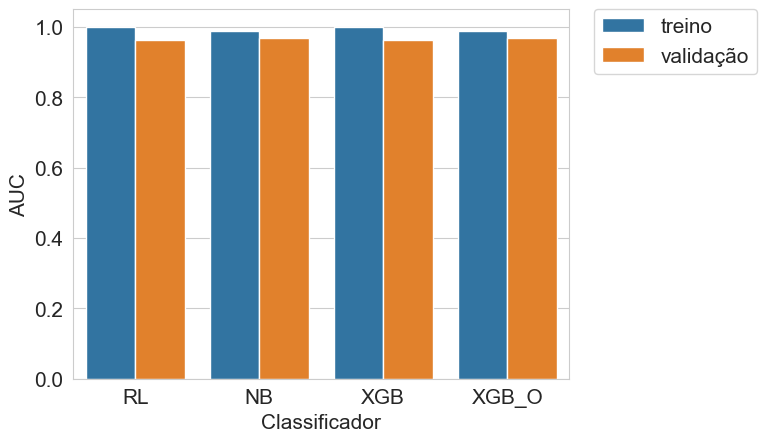

In [ ]:
# Configuração do estilo do gráfico
# Define o estilo como "whitegrid" para melhorar a visualização com um fundo branco e grades suaves
sns.set_style("whitegrid")

# Criação do gráfico de barras
# O gráfico compara os valores da métrica AUC para cada classificador nos conjuntos de treino e validação
ax = sns.barplot(
    x='classificador',  # Eixo X: Nome do modelo
    y='auc',            # Eixo Y: Valor da AUC
    hue='data_set',     # Diferencia os resultados de treino e validação
    data=df_results     # DataFrame contendo os resultados
)

# Configuração dos eixos
# Define o rótulo do eixo X com tamanho maior para melhor legibilidade
ax.set_xlabel('Classificador', fontsize=15)
# Define o rótulo do eixo Y com tamanho maior para melhor visualização da métrica AUC
ax.set_ylabel('AUC', fontsize=15)
# Ajusta o tamanho das marcações nos eixos para facilitar a leitura
ax.tick_params(labelsize=15)

# Configuração da legenda
# Posiciona a legenda fora do gráfico para melhor organização visual
plt.legend(
    bbox_to_anchor=(1.05, 1),   # Define a posição da legenda fora do gráfico, à direita
    loc=2,                      # Define a posição da âncora
    borderaxespad=0.,           # Remove espaçamento entre o gráfico e a legenda
    fontsize=15                 # Ajusta o tamanho da fonte da legenda
)

# Exibição do gráfico
plt.show()

In [57]:
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL,treino,1.000000,1.000000,1.000000,1.000000,1.000000
1,RL,validação,0.962315,0.886667,0.939394,1.000000,1.000000
2,NB,treino,0.988720,0.932258,0.941935,0.924051,0.922581
3,NB,validação,0.967366,0.886667,0.909091,0.681818,0.880342
4,XGB,treino,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGB,validação,0.962315,0.986667,0.939394,1.000000,1.000000
6,XGB_O,treino,0.988720,0.932258,0.941935,0.924051,0.922581
7,XGB_O,validação,0.967366,0.886667,0.909091,0.681818,0.880342


In [ ]:
# Filtra os resultados para exibir apenas os dados do conjunto de validação
# Isso permite comparar o desempenho dos modelos nos dados que não foram usados no treinamento
df_results[df_results['data_set'] == 'validação'].sort_values(by='auc', ascending=False)
# Ordena os modelos com base na métrica AUC (Área sob a Curva ROC)
# O parâmetro ascending=False garante que os modelos com maior AUC apareçam primeiro na tabela

,classificador,data_set,auc,accuracy,recall,precision,specificity
3,NB,validação,0.967366,0.886667,0.909091,0.681818,0.880342
7,XGB_O,validação,0.967366,0.886667,0.909091,0.681818,0.880342
1,RL,validação,0.962315,0.886667,0.939394,1.000000,1.000000
5,XGB,validação,0.962315,0.986667,0.939394,1.000000,1.000000


-----

### **Resumo da Comparação dos Modelos**  

- **XGB (XGBoost) teve o melhor desempenho geral** com **acurácia de 0.987, recall de 0.939 e precisão perfeita de 1.000**, garantindo equilíbrio entre identificação de positivos e minimização de falsos positivos.  
- **NB e XGB_O apresentaram o maior AUC (0.967)**, mas com **precisão baixa (0.682)**, indicando maior risco de falsos positivos.  
- **RL teve recall mais alto (0.939) e precisão perfeita (1.000), mas acurácia menor (0.887)**.  

### **Escolha Recomendada**  
Se o foco for **desempenho equilibrado**, **XGB é a melhor opção**.  
Se for **maximizar recall**, **RL pode ser uma alternativa viável**.  
Se precisar de **um modelo mais interpretável**, **NB pode ser considerado, mas exige ajustes para melhorar a precisão**.

-----

In [60]:
# Grava o modelo em disco
# Salva o modelo treinado 'modelo_dsa_v4' no arquivo 'melhor_modelo_dsa.pkl'
# 'wb' significa "write binary", pois estamos salvando um objeto binário
# protocol=4 garante compatibilidade com versões mais recentes do Python
pickle.dump(modelo_ajustado_hiperparametro, open('melhor_modelo.pkl', 'wb'), protocol=4) # type: ignore

---
### **Conclusão da Análise**  

Com base nas métricas avaliadas, o modelo **XGBoost (XGB)** se destacou como a melhor opção para equilibrar **acurácia, recall e precisão**, garantindo previsões confiáveis sem comprometer a minimização de falsos positivos. Modelos como **NB e XGB_O** apresentaram um AUC ligeiramente superior, mas sua baixa precisão pode levar a decisões menos eficientes na priorização de contatos.  

Diante disso, **fomos capazes de responder ao desafio proposto**: identificar padrões nos dados dos clientes e prever a **probabilidade de conversão já no primeiro contato**. Com um modelo otimizado, a empresa pode antecipar quais prospects têm maior probabilidade de fechar contrato, permitindo que os atendentes priorizem esses contatos e otimizem os esforços de venda de forma mais eficiente.  

Caso seja necessário um refinamento adicional, ajustes nos hiperparâmetros podem ser explorados para melhorar ainda mais a generalização do modelo.

---

In [61]:
%watermark -a "Ricardo de Souza Silva"

Author: Ricardo de Souza Silva



In [62]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 23 Model 96 Stepping 1, AuthenticAMD
CPU cores   : 12
Architecture: 64bit



In [63]:
%watermark --iversions

pandas    : 2.2.2
xgboost   : 2.1.2
seaborn   : 0.13.2
matplotlib: 3.8.4
numpy     : 1.26.4
sklearn   : 1.4.2



# Fim